<a href="https://colab.research.google.com/github/martinpius/RNN-ALIENS/blob/main/RNN_with_Complex_input_structure%2C_Masking_and_Padding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount("/content/drive/", force_remount = True)
try:
  COLAB = True
  import tensorflow as tf
  print(f"You are on Google Colab with tensorflow version: {tf.__version__}")
except Exception as e:
  COLAB = False
  print(f"{type(e)}: {e}\n...Please Load Your Drive...")
def time_fmt(x):
  h = int(x / (60 * 60))
  m = int(x % (60 * 60) / 60)
  s = int(x % 60)
  return f"{h}:{m:>03}: {s:>05.2f}"

display(time_fmt(123.43598))


Mounted at /content/drive/
You are on Google Colab with tensorflow version: 2.4.0


'0:002: 03.00'

In [59]:
import tensorflow as tf
import numpy as np
from tensorflow import keras

In [2]:
#Sometimes we may need to pass a comple data structure to an LSTM cell. In this case we can 
#pass the nested data as list or dictionsry

In [3]:
#We design an LSTM nested cell from scratch using layers subclassing

In [36]:
class NestedCell(tf.keras.layers.Layer):
  def __init__(self, unit_1, unit_2, unit_3, **kwargs):
    self.unit_1 = unit_1
    self.unit_2 = unit_2 
    self.unit_3 = unit_3 
    self.state_size = [tf.TensorShape([unit_1]), tf.TensorShape([unit_2, unit_3])]
    self.output_size = [tf.TensorShape([unit_1]), tf.TensorShape([unit_2, unit_3])]
    super(NestedCell, self).__init__(**kwargs)
  
  def build(self, input_shapes):
    i1 = input_shapes[0][1]
    i2 = input_shapes[1][1]
    i3 = input_shapes[1][2]

    self.kernel_1 = self.add_weight(shape = (i1, self.unit_1),
                                    initializer = 'uniform',
                                    name = 'kernel_1')
    self.kernel_2_3 = self.add_weight(shape = (i2, i3, self.unit_2, self.unit_3),
                                      initializer = 'uniform',
                                      name = 'kernel_2_3')
  
  def call(self, inputs, states):
    input_1, input_2 = tf.nest.flatten(inputs)
    s1,s2 = states
    output_1 = tf.matmul(input_1, self.kernel_1)
    output_2_3 = tf.einsum('bij , ijkl->bkl', input_2, self.kernel_2_3)
    state_1 = s1 + output_1
    state_2_3 = s2 + output_2_3
    output = (output_1, output_2_3)
    new_state = (state_1, state_2_3)
    return output, new_state
  
  def get_config(self):
    return {'unit_1': self.unit_1, 'unit_2' : self.unit_2, 'unit_3' : self.unit_3}

In [37]:
#Instantiate the class

In [40]:
unit_1 = 10
unit_2 = 20
unit_3 = 30
i1 = 64
i2 = 32
i3 = 16
batch_size = 64
time_steps = 50
batch_num = 10
cell = NestedCell(unit_1, unit_2, unit_3)
rnn = tf.keras.layers.RNN(cell)
input_1 = tf.keras.Input(shape = (None, i1))
input_2 = tf.keras.Input(shape = (None, i2, i3))
outputs = rnn((input_1, input_2))

In [41]:
model = tf.keras.Model(inputs = [input_1, input_2], outputs = outputs)

In [42]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_31 (InputLayer)           [(None, None, 64)]   0                                            
__________________________________________________________________________________________________
input_32 (InputLayer)           [(None, None, 32, 16 0                                            
__________________________________________________________________________________________________
rnn_15 (RNN)                    ((None, 10), (None,  307840      input_31[0][0]                   
                                                                 input_32[0][0]                   
Total params: 307,840
Trainable params: 307,840
Non-trainable params: 0
__________________________________________________________________________________________________


In [43]:
#fake_data for the model

In [44]:
input_1 = np.random.random(size = (batch_size * num_batches, time_steps, i1))
input_2 = np.random.random(size = (batch_size * num_batches, time_steps, i2, i3))
out1 = np.random.random(size = (batch_size *num_batches, unit_1))
out2 = np.random.random(size = (batch_size * num_batches, unit_2, unit_3))
inputs = [input_1, input_2]
target = [out1, out2]


In [45]:
model.compile(loss = 'mse', metrics = ['accuracy'], optimizer = 'Adam')

In [46]:
model.fit(inputs, target, verbose = 2, epochs = 5, validation_split=0.10)

Epoch 1/5
18/18 - 4s - loss: 0.3471 - rnn_15_loss: 0.1681 - rnn_15_1_loss: 0.1790 - rnn_15_accuracy: 0.0955 - rnn_15_1_accuracy: 0.0339 - val_loss: 0.2265 - val_rnn_15_loss: 0.0914 - val_rnn_15_1_loss: 0.1352 - val_rnn_15_accuracy: 0.1250 - val_rnn_15_1_accuracy: 0.0312
Epoch 2/5
18/18 - 2s - loss: 0.2176 - rnn_15_loss: 0.0934 - rnn_15_1_loss: 0.1243 - rnn_15_accuracy: 0.0868 - rnn_15_1_accuracy: 0.0355 - val_loss: 0.2158 - val_rnn_15_loss: 0.0936 - val_rnn_15_1_loss: 0.1222 - val_rnn_15_accuracy: 0.0312 - val_rnn_15_1_accuracy: 0.0305
Epoch 3/5
18/18 - 2s - loss: 0.2029 - rnn_15_loss: 0.0893 - rnn_15_1_loss: 0.1137 - rnn_15_accuracy: 0.0868 - rnn_15_1_accuracy: 0.0397 - val_loss: 0.2081 - val_rnn_15_loss: 0.0890 - val_rnn_15_1_loss: 0.1191 - val_rnn_15_accuracy: 0.0938 - val_rnn_15_1_accuracy: 0.0273
Epoch 4/5
18/18 - 2s - loss: 0.1963 - rnn_15_loss: 0.0882 - rnn_15_1_loss: 0.1081 - rnn_15_accuracy: 0.0972 - rnn_15_1_accuracy: 0.0411 - val_loss: 0.2075 - val_rnn_15_loss: 0.0888 - val_

In [48]:
#Padding and masking in sequence data
#Most of time we are required to padd the sequence data so as to retain uniformity
#of member's length. When we divide the sequence into batches it is crucial for the
#contigous batches to be of the same length. Therefore, padding is useful to guarantee that.

In [29]:
dfm = [
         ['hello', 'sam','how','are','you'],
         ['today','I','feel','super','fatigue'],
         ['probably','you','hsve','cold'],
         ['try','to','rest'],
         ['thanks','bye']
]

In [30]:
from tensorflow.keras.layers.experimental import preprocessing

In [ ]:
#Lets create a ragged tensor for the above nested list

In [31]:
dfm = tf.ragged.constant(dfm)

In [35]:
#Obtaining the indices for each word in the nested list using stringlookup from layer's preprocessing method

In [36]:
layer = preprocessing.StringLookup()

In [37]:
layer.adapt(dfm)

In [39]:
data = layer(dfm)

In [43]:
data.to_list()

[[13, 8, 12, 18, 2], [4, 19, 14, 7, 15], [10, 2, 11, 16], [3, 5, 9], [6, 17]]

In [44]:
#Now we can pad the above data to create a tensor of suitable shape to train a given deep-learning model

In [46]:
padded_data = tf.keras.preprocessing.sequence.pad_sequences(data.to_list(), padding = 'post')

In [47]:
padded_data

array([[13,  8, 12, 18,  2],
       [ 4, 19, 14,  7, 15],
       [10,  2, 11, 16,  0],
       [ 3,  5,  9,  0,  0],
       [ 6, 17,  0,  0,  0]], dtype=int32)

In [48]:
#Since the padded data contain 0's which are actually of no information to the sequence we need to
#hide/mask them during training (This can be done using an embedding layer with mask_zero set to true)

In [52]:
my_embedding = tf.keras.layers.Embedding(input_dim = 100, output_dim = 20, mask_zero = True)

In [53]:
masked_data = my_embedding(padded_data)

In [55]:
masked_data.shape

TensorShape([5, 5, 20])

In [62]:
#We can obtain the mask as follow (This will be nested list of booleans with false inplace of zeros) 
#with same dimension as the padded data

In [63]:
print(masked_data._keras_mask)

tf.Tensor(
[[ True  True  True  True  True]
 [ True  True  True  True  True]
 [ True  True  True  True False]
 [ True  True  True False False]
 [ True  True False False False]], shape=(5, 5), dtype=bool)


In [64]:
#We can propagate the mask to any layer which is capable of recognizing the mask down the network by passing it
#one time at the embedding layer

In [67]:
inputs = tf.keras.Input(shape = (10,),name = 'input_dim')
x = tf.keras.layers.Embedding(input_dim = 1000, 
                              output_dim = 64, 
                              mask_zero = True, 
                              name = 'embedding_with_a_mask')(inputs)
x = tf.keras.layers.LSTM(units = 128, 
                         return_sequences = True, 
                         dropout = 0.5,
                         recurrent_dropout = True,
                         kernel_initializer ='random_normal',
                         name = 'lstm_layer')(x)
x = tf.keras.layers.SimpleRNN(units = 64, 
                              return_sequences =True,
                              recurrent_dropout = True,
                              dropout = True,
                              kernel_initializer = 'random_normal',
                              name = 'rnn_layer')(x)
x = tf.keras.layers.Dense(1024, activation = 'relu',
                          kernel_initializer = 'random_normal',
                          name = 'dense_layer')(x)
x = tf.keras.layers.Dropout(rate = 0.5, name = 'dropout')(x)
outputs = tf.keras.layers.Dense(units = 10, activation = 'softmax', name = 'output_layer')(x)

In [68]:
model = tf.keras.Model(inputs = inputs, outputs = outputs, name = 'mask_rnn')

Model: "mask_rnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_dim (InputLayer)       [(None, 10)]              0         
_________________________________________________________________
embedding_with_a_mask (Embed (None, 10, 64)            64000     
_________________________________________________________________
lstm_layer (LSTM)            (None, 10, 128)           98816     
_________________________________________________________________
rnn_layer (SimpleRNN)        (None, 10, 64)            12352     
_________________________________________________________________
dense_layer (Dense)          (None, 10, 1024)          66560     
_________________________________________________________________
dropout (Dropout)            (None, 10, 1024)          0         
_________________________________________________________________
output_layer (Dense)         (None, 10, 10)            102

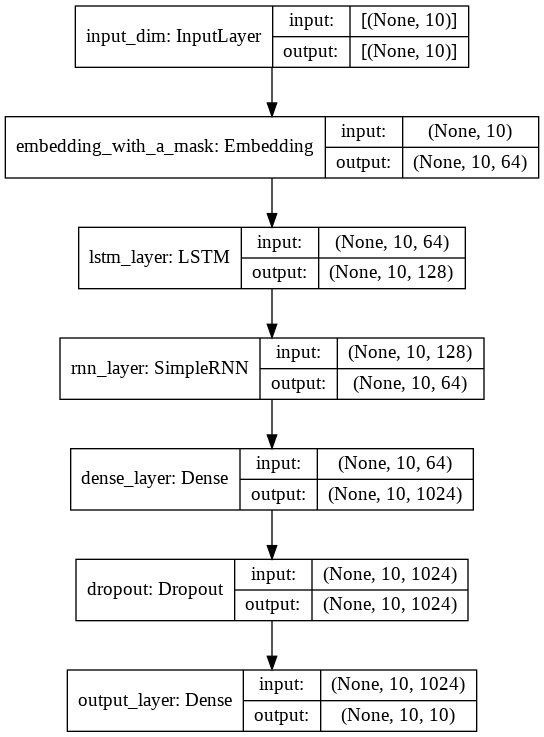

In [69]:
model.summary()
tf.keras.utils.plot_model(model = model, to_file = 'mask_rnn.png', show_shapes = True)